In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from econml.dml import CausalForestDML
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

In [3]:
df_offenses = pd.read_csv('ca_offenses_by_city.csv')
df_law_enforcement = pd.read_csv('ca_law_enforcement_by_city.csv')
df = pd.merge(df_law_enforcement, df_offenses.drop('Population', axis=1), on='City', how='inner')
df

,City,Population,Total law enforcement employees,Total officers,Total civilians,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson
0,Alameda,"78,613",112,83,29,148,2,7,NaN,61,78,"1,819",228,"1,245",346,18
1,Albany,"19,723",30,23,7,34,1,6,NaN,16,11,605,95,447,63,0
2,Anderson,"10,277",24,18,6,88,0,4,NaN,9,75,474,60,358,56,2
3,Antioch,"110,537",115,91,24,771,7,53,NaN,280,431,"3,912",862,"2,026","1,024",36
4,Arcadia,"58,694",93,68,25,68,1,6,NaN,31,30,"1,272",316,892,64,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Willows,"6,074",9,8,1,40,0,5,NaN,4,31,190,24,148,18,2
213,Winters,"7,023",13,11,2,24,0,2,NaN,1,21,111,17,80,14,1
214,Woodland,"57,911",77,62,15,265,1,16,NaN,51,197,"1,798",326,"1,230",242,15
215,Yreka,"7,507",19,13,6,47,1,4,NaN,4,38,309,85,188,36,1


In [9]:
Y = np.array(df['Violent crime'].str.replace(',', '').astype(float))
Z = np.array(df['Total law enforcement employees'].str.replace(',', '').astype(float))
T = np.array(df['Total officers'].str.replace(',', '').astype(float))
X = np.array(df['Population'].str.replace(',', '').astype(float)).reshape(-1, 1) 
X_train, X_test, T_train, T_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, T, Y, Z, test_size=0.2, random_state=0)

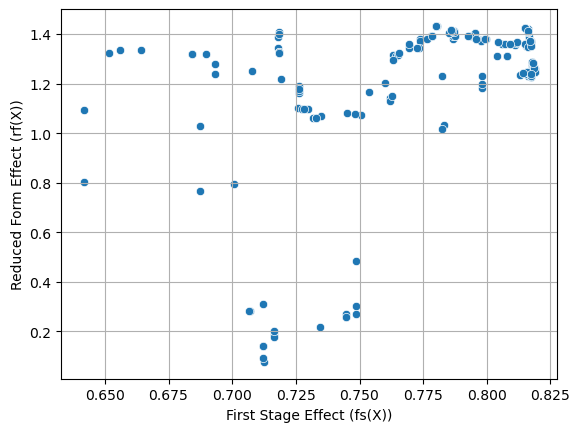

Correlation coefficient between first stage and reduced form: 0.48716625717498563
Spearman's rank correlation coefficient: 0.24931694919148126
Kendall's tau rank correlation coefficient: 0.1368029062231666


In [10]:
causal_forest_fs = CausalForestDML(discrete_treatment=False)
causal_forest_fs.fit(T, Z, X=X, W=None)
fs_cate = causal_forest_fs.effect(X)

causal_forest_rf = CausalForestDML(discrete_treatment=False)
causal_forest_rf.fit(Y, Z, X=X, W=None)
rf_cate = causal_forest_rf.effect(X)

sns.scatterplot(x=fs_cate, y=rf_cate)
plt.xlabel('First Stage Effect (fs(X))')
plt.ylabel('Reduced Form Effect (rf(X))')
plt.grid(True)
plt.show()

corr = np.corrcoef(fs_cate, rf_cate)[0, 1]
print("Correlation coefficient between first stage and reduced form:", corr)

spearman_corr, _ = scipy.stats.spearmanr(fs_cate, rf_cate)
print("Spearman's rank correlation coefficient:", spearman_corr)

kendall_corr, _ = scipy.stats.kendalltau(fs_cate, rf_cate)
print("Kendall's tau rank correlation coefficient:", kendall_corr)

In [11]:
tsls = IV2SLS(Y_train, T_train, Z_train).fit()
# tsls.summary()
r2_tsls = tsls.rsquared
print("R-squared for tsls model:", r2_tsls)

Y_test_pred = tsls.predict(T_test)
r2_rf = r2_score(Y_test, Y_test_pred)
print("R-squared for tsls model:", r2_rf)
T_test_pred = tsls.predict(Y_test)
r2_fs = r2_score(T_test, T_test_pred)
print("R-squared for tsls model:", r2_fs)

R-squared for tsls model: 0.950192955906832
R-squared for tsls model: 0.7248041126016302
R-squared for tsls model: -157.95921791661107
